In [3]:
import numpy as np
import os
import cv2
#import h5py
import torch
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Datasets/Dataset_train.h5 /content
!cp /content/drive/MyDrive/Datasets/Dataset_test.h5 /content

cp: cannot stat '/content/drive/MyDrive/Datasets/Dataset_train.h5': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Datasets/Dataset_test.h5': No such file or directory


In [ ]:
import h5py
import numpy as np
file = h5py.File('Dataset_train.h5', 'r')
img_train = file.get('images')
mask_train = file.get('masks')
img_train = np.array(img_train)
mask_train = np.array(mask_train)

img_train = img_train.astype('float32')
img_train /= 255

mask_train = mask_train.astype('float32')
mask_train /= 255  # scale masks to [0, 1]

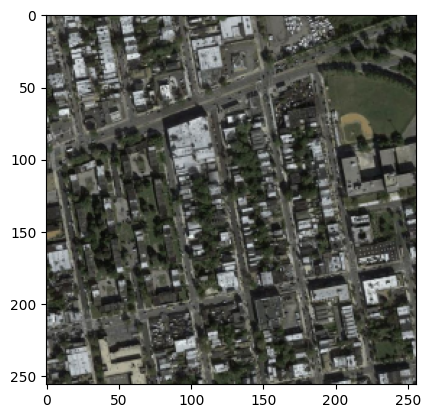

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img_train[0])
plt.show()


In [ ]:
img_train[0].shape

(256, 3)

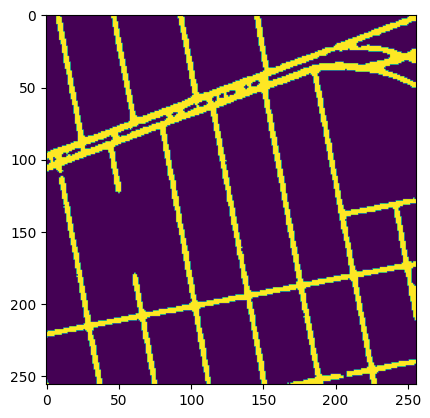

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(mask_train[0])
plt.show()

In [4]:
import torch.nn as nn

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = ConvBlock(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = EncoderBlock(3, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        """ Bottleneck """
        self.b = ConvBlock(512, 1024)
        """ Decoder """
        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs.permute(0, 3, 1, 2))
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [ ]:
model = UNet()


In [ ]:
#fp16
model.half()
for i in model.modules():
  if isinstance(i,nn.BatchNorm2d):
    i.float()

In [ ]:
from sklearn.model_selection import train_test_split
image_train, image_val, mask_train, mask_val = train_test_split(
    img_train, mask_train, test_size=0.2, random_state=42
)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(torch.from_numpy(image_train), torch.from_numpy(mask_train))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
val_dataset = TensorDataset(torch.from_numpy(image_val), torch.from_numpy(mask_val))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        masks = masks.permute(0, 3, 1, 2)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            masks = masks.permute(0, 3, 1, 2)
            val_loss += criterion(outputs, masks).item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/10], Loss: 0.1245, Val Loss: 0.1121
Epoch [2/10], Loss: 0.1255, Val Loss: 0.1200
Epoch [3/10], Loss: 0.0861, Val Loss: 0.1095
Epoch [4/10], Loss: 0.1811, Val Loss: 0.1089
Epoch [5/10], Loss: 0.1114, Val Loss: 0.1218
Epoch [6/10], Loss: 0.0875, Val Loss: 0.1152
Epoch [7/10], Loss: 0.0793, Val Loss: 0.1052
Epoch [8/10], Loss: 0.0968, Val Loss: 0.1083
Epoch [9/10], Loss: 0.1157, Val Loss: 0.1095
Epoch [10/10], Loss: 0.0728, Val Loss: 0.1087


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/segmentation-model2.pth")


In [ ]:
import torch
model2 = UNet()
model2.load_state_dict(torch.load("/content/drive/MyDrive/segmentation-model2.pth"))
model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

UNet(
  (e1): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=

In [ ]:
input_image.shape

torch.Size([256, 3])

torch.Size([1, 256, 256, 3])


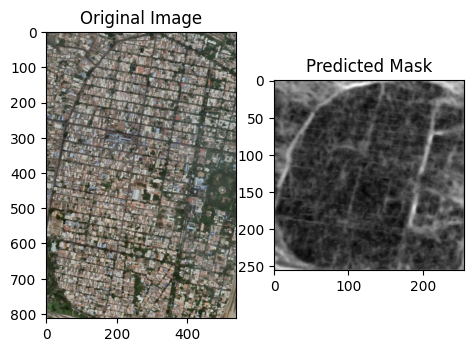

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

image_path = "/content/test-image.jpg"
image = Image.open(image_path)

#preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])

input_image =preprocess(image).unsqueeze(0)  # Add batch dim

# Permute the dimensions of the input image
input_image = input_image.permute(0, 2, 3, 1)  # [1, 256, 3, 256]

input_image = input_image.to(device)

print(input_image.shape)

model2.eval()

with torch.no_grad():
    predicted_mask = model2(input_image)

# predicted_mask = torch.sigmoid(predicted_mask)

predicted_mask = predicted_mask.squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(image.size[0] / 100, image.size[1] / 100))
axes[0].imshow(image)
axes[0].set_title('Original Image')

axes[1].imshow(predicted_mask, cmap='gray')  # Invert colors by subtracting from 1
axes[1].set_title('Predicted Mask')

plt.show()
